## Neural Collaborative Filtering Model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import reduce
from itertools import product
from sklearn.model_selection import train_test_split
from itertools import product
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input,Embedding,Flatten,Dense,Concatenate,Dropout,BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# data_dir = "/content/drive/MyDrive/Data"
# extended_interactions = pd.read_pickle(f'{data_dir}/interactions_extended.pkl')
# extended_recipes = pd.read_pickle(f'{data_dir}/recipes_extended.pkl')
data_dir = "../data"
extended_interactions = pd.read_pickle(f'{data_dir}/interactions_extended.pkl')
extended_recipes = pd.read_pickle(f'{data_dir}/recipes_extended.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
extended_interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 15 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   user_id                 1132367 non-null  int64         
 1   recipe_id               1132367 non-null  int64         
 2   date                    1132367 non-null  datetime64[ns]
 3   rating                  1132367 non-null  int64         
 4   review                  1132367 non-null  object        
 5   year                    1132367 non-null  int32         
 6   month                   1132367 non-null  int32         
 7   day_of_week             1132367 non-null  int32         
 8   days_since              1132367 non-null  int64         
 9   interaction_count       1132367 non-null  int64         
 10  rating_scaled           1132367 non-null  float64       
 11  user_avg_rating_scaled  1132367 non-null  float64       
 12  review_length 

In [4]:
extended_recipes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231636 entries, 0 to 231636
Data columns (total 86 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   name                    231636 non-null  object        
 1   id                      231636 non-null  int64         
 2   minutes                 231636 non-null  int64         
 3   contributor_id          231636 non-null  int64         
 4   submitted               231636 non-null  datetime64[ns]
 5   tags                    231636 non-null  object        
 6   nutrition               231636 non-null  object        
 7   n_steps                 231636 non-null  int64         
 8   steps                   231636 non-null  object        
 9   description             231636 non-null  object        
 10  ingredients             231636 non-null  object        
 11  n_ingredients           231636 non-null  int64         
 12  calories                231636 non-

### Preparing data - Encode user_id and recipe_id

Some interactions might reference recipes that are missing from the recipe dataset. Let’s remove any interactions where the recipe is not present in the recipe data.

In [5]:
valid_recipes_ids = set(extended_recipes['id'])
extended_interactions = extended_interactions[ extended_interactions['recipe_id'].isin(valid_recipes_ids)].reset_index(drop=True)

In [6]:
recipe_encoder = LabelEncoder()
user_encoder = LabelEncoder()
recipe_encoder.fit(extended_recipes['id'])

extended_recipes['recipe_idx'] = recipe_encoder.transform(extended_recipes['id'])
extended_interactions['recipe_idx'] = recipe_encoder.transform(extended_interactions['recipe_id'])
extended_interactions['user_idx'] = user_encoder.fit_transform(extended_interactions['user_id'])

Just to be sure, we check that no encoded index exceeds the embedding size

In [7]:
assert extended_interactions['recipe_idx'].max() < recipe_encoder.classes_.shape[0]
assert extended_interactions['user_idx'].max() < user_encoder.classes_.shape[0]

In [8]:
print("interactions_idx min (interactions):", extended_interactions['recipe_idx'].min())
print("interactions_idx max (interactions):", extended_interactions['recipe_idx'].max())
print("recipe_idx min (recipes):", extended_recipes['recipe_idx'].min())
print("recipe_idx max (recipes):", extended_recipes['recipe_idx'].max())
print("user_idx min:", extended_interactions['user_idx'].min())
print("user_idx max:", extended_interactions['user_idx'].max())

interactions_idx min (interactions): 0
interactions_idx max (interactions): 231635
recipe_idx min (recipes): 0
recipe_idx max (recipes): 231635
user_idx min: 0
user_idx max: 226568


### Prepare train and test datasets for modeling

In [9]:
user_ids = extended_interactions['user_idx'].values
recipe_ids = extended_interactions['recipe_idx'].values
ratings = extended_interactions['rating_scaled'].values
num_users = extended_interactions['user_idx'].nunique()
num_recipes = extended_recipes['recipe_idx'].nunique()

In [10]:
X_train_ids, X_test_ids, y_train, y_test = train_test_split(np.arange(len(user_ids)), ratings, test_size=0.2, random_state=999)

X_train = [user_ids[X_train_ids], recipe_ids[X_train_ids]]
X_test = [user_ids[X_test_ids], recipe_ids[X_test_ids]]


In [11]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=128):
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, callbacks=[early_stop],verbose=1)

    y_pred = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return model, history

In [12]:
def plot_training(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## Model 1. Basic Neural Collaborative Filtering

Neural Collaborative Filtering (NCF) uses embedding layers for users and items, and then combines those embeddings using a fully connected neural network.

In [13]:
def build_basic_ncf(num_users, num_recipes, embed_dim, dense_units, dropout_rate, learning_rate):
    # === Optimizer ===
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # === Inputs ===
    user_input = Input(shape=(1,), name='user')
    recipe_input = Input(shape=(1,), name='recipe')
    # === Embeddings ===
    user_embedding = Embedding(input_dim=num_users, output_dim=embed_dim)(user_input)
    recipe_embedding = Embedding(input_dim=num_recipes, output_dim=embed_dim)(recipe_input)
    # === Flatten embeddings ===
    user_vec = Flatten()(user_embedding)
    recipe_vec = Flatten()(recipe_embedding)
    # === Concatenate embeddings ===
    x = Concatenate()([user_vec, recipe_vec])
    # === Dense layers ===
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units // 2, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[user_input, recipe_input], outputs=output)
    model.compile(optimizer=optimizer,loss='mse', metrics=['mae'])
    return model

### Train and evaluate

In [14]:
model_basic_ncf = build_basic_ncf(
    num_users=num_users,
    num_recipes=num_recipes,
    embed_dim=16,
    dense_units=128,
    dropout_rate=0.3,
    learning_rate=0.0005
)

model_basic_ncf, history_basic_ncf = train_and_evaluate(model_basic_ncf, X_train, y_train, X_test, y_test)

Epoch 1/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0743 - mae: 0.1902 - val_loss: 0.0655 - val_mae: 0.1694
Epoch 2/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0463 - mae: 0.1317 - val_loss: 0.0711 - val_mae: 0.1683
Epoch 3/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0329 - mae: 0.1023 - val_loss: 0.0718 - val_mae: 0.1647
Epoch 4/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0278 - mae: 0.0889 - val_loss: 0.0736 - val_mae: 0.1654
7078/7078 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
MAE: 0.1687, RMSE: 0.2551


### Plotting results

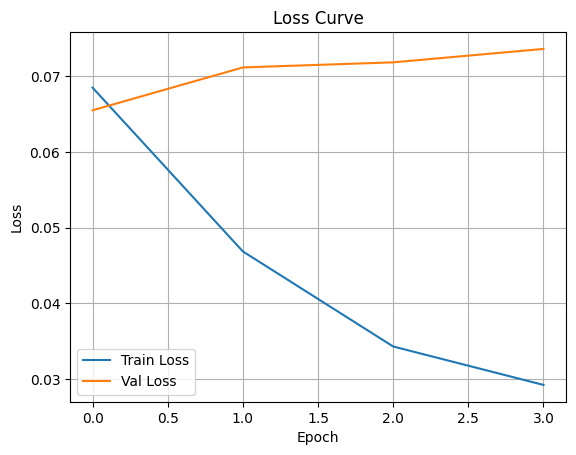

In [15]:
plot_training(history_basic_ncf)

## Model 2. Improved Neural Collaborative Filtering

In [16]:
 #Randomly sample a fraction of X and y, maintaining alignment.
def sample_dataset(X, y, fraction=0.05, random_state=999):
    total_samples = len(y)
    sample_size = int(total_samples * fraction)

    rng = np.random.RandomState(seed=random_state)
    indices = rng.choice(total_samples, size=sample_size, replace=False)

    if isinstance(X, list):
        X_sampled = [np.array(x)[indices] for x in X]
    else:
        X_sampled = np.array(X)[indices]

    y_sampled = np.array(y)[indices]
    return X_sampled, y_sampled

In [17]:
def split_inputs(X, y, test_size=0.2, random_state=999):
    total = len(y)
    indices = np.arange(total)
    train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=random_state)

    if isinstance(X, list):
        X_train = [x[train_idx] for x in X]
        X_test = [x[test_idx] for x in X]
    else:
        X_train = X[train_idx]
        X_test = X[test_idx]

    return X_train, X_test, y[train_idx], y[test_idx]

In [18]:
def test_parameters(model_function, X, y, model_kwargs={}, sample_frac=0.05, epochs=10, batch_size=128, verbose=1):

    X_sampled, y_sampled = sample_dataset(X, y, fraction=sample_frac)
    X_train, X_test, y_train, y_test = split_inputs(X_sampled, y_sampled)

    model = model_function(**model_kwargs)
    model, history = train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=epochs, batch_size=batch_size)
    return model, history


In [19]:
def expand_grid(param_grid):
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    for combo in product(*values):
        yield dict(zip(keys, combo))

In [20]:
def find_best_hyperparams(model_function, X, y, param_grid, base_kwargs={}, sample_frac=0.05, epochs=10, batch_size=128):
    records = []

    for params in expand_grid(param_grid):
        print("Testing:", params)
        model, history = test_parameters(
            model_function=model_function,
            X=X,
            y=y,
            model_kwargs={**base_kwargs, **params},
            sample_frac=sample_frac,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
        final_val_loss = history.history['val_loss'][-1]
        records.append({**params, 'val_loss': final_val_loss})

    df = pd.DataFrame(records)
    df_sorted = df.sort_values(by='val_loss').reset_index(drop=True)

    best_params = df_sorted.iloc[0]  # returns a Series
    return df_sorted, best_params

In [21]:
def build_ncf(num_users, num_recipes, embed_dim, dense_units, dropout_rate, learning_rate, l2_reg=1e-5):
    # === Optimizer ===
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # === Regulizer ===
    regularizer=tf.keras.regularizers.l2(l2_reg)
    # === Inputs ===
    user_input = Input(shape=(1,), name='user')
    recipe_input = Input(shape=(1,), name='recipe')
    # === Embeddings ===
    user_embedding = Embedding(input_dim=num_users, output_dim=embed_dim, embeddings_regularizer=regularizer )(user_input)
    recipe_embedding = Embedding(input_dim=num_recipes, output_dim=embed_dim, embeddings_regularizer=regularizer)(recipe_input)
    # === Flatten embeddings ===
    user_vec = Flatten()(user_embedding)
    recipe_vec = Flatten()(recipe_embedding)
    # === Concatenate embeddings ===
    x = Concatenate()([user_vec, recipe_vec])
    x = BatchNormalization()(x)
    # === Dense layers ===
    x = Dense(dense_units, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units // 2, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(dropout_rate)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[user_input, recipe_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='mse', metrics=['mae'])
    return model

### Finding best parameters

In [22]:
param_grid = {
    'embed_dim': [16, 32],
    'dense_units': [64, 128],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.0005]
}

In [23]:
base_kwargs = {
    'num_users': num_users,
    'num_recipes': num_recipes
}

In [24]:
results, best_params = find_best_hyperparams(
    model_function=build_ncf,
    X=[user_ids, recipe_ids],
    y=ratings,
    param_grid=param_grid,
    base_kwargs=base_kwargs
)

Testing: {'embed_dim': 16, 'dense_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.1089 - mae: 0.2224 - val_loss: 0.0840 - val_mae: 0.2289
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0520 - mae: 0.1347 - val_loss: 0.0866 - val_mae: 0.2028
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0280 - mae: 0.0862 - val_loss: 0.0965 - val_mae: 0.2070
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0200 - mae: 0.0684 - val_loss: 0.0903 - val_mae: 0.1938
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MAE: 0.2309, RMSE: 0.2847
Testing: {'embed_dim': 16, 'dense_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0005}
Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1221 - mae: 0.2419 - val_loss: 0.0872 - val_mae: 0.2371
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0609 - mae: 0.1508 - val_loss: 0.0864 - val_mae: 0.2170
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 

In [25]:
print("Best learning rate:", best_params['learning_rate'])
print("Best dropout:", best_params['dropout_rate'])
print("Best embed_dim:", best_params['embed_dim'])
print("Best dense_units:", best_params['dense_units'])

Best learning rate: 0.001
Best dropout: 0.3
Best embed_dim: 16.0
Best dense_units: 128.0


### Train and evaluate

In [26]:
best_params = best_params.drop('val_loss').to_dict()
best_params["embed_dim"] = int(best_params["embed_dim"])
best_params["dense_units"] = int(best_params["dense_units"])

In [27]:
best_model_ncf = build_ncf(
    **base_kwargs,
    **best_params
)

# Full train/test split on all data
X = [user_ids, recipe_ids]
X_train, X_test, y_train, y_test = split_inputs(X, ratings)

best_model_ncf, history_ncf = train_and_evaluate(best_model_ncf, X_train, y_train, X_test, y_test)

Epoch 1/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0785 - mae: 0.1785 - val_loss: 0.0752 - val_mae: 0.1732
Epoch 2/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0671 - mae: 0.1549 - val_loss: 0.0757 - val_mae: 0.1742
Epoch 3/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0578 - mae: 0.1395 - val_loss: 0.0791 - val_mae: 0.1740
Epoch 4/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0610 - mae: 0.1430 - val_loss: 0.0782 - val_mae: 0.1681
7078/7078 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
MAE: 0.1729, RMSE: 0.2576


### Plotting results

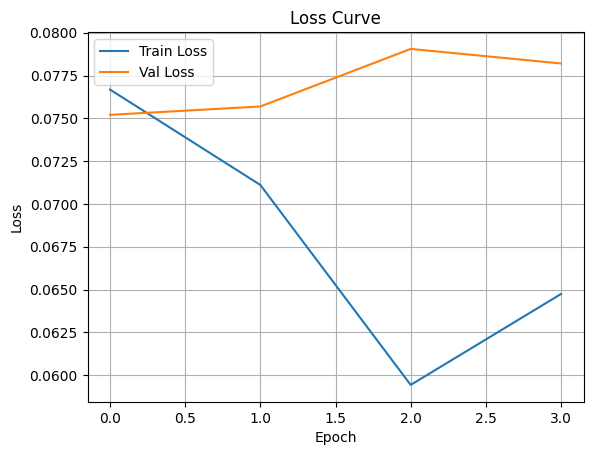

In [28]:
plot_training(history_ncf)

## Model 3. Hybrid Collaborative Filtering + Content Base

Remove columns that are non-numeric and heavy in text that are not suitable for neural models. Get features vectors for recipe and interactions

In [29]:
non_numeric = extended_recipes.select_dtypes(include=['object', 'category']).columns
manual_exclude = ['id', 'submitted', 'contributor_id', 'recipe_idx']

columns_to_exclude = set(non_numeric).union(set(manual_exclude))
recipe_feature_columns = [ col for col in extended_recipes.select_dtypes(include=[np.number]).columns if col not in columns_to_exclude ]

#These are the recipe selected features to use later
recipes_selected_features = extended_recipes[recipe_feature_columns].values
print(recipe_feature_columns)

['minutes', 'n_steps', 'n_ingredients', 'calories', 'total_fat_pdv', 'sugar_pdv', 'sodium_pdv', 'protein_pdv', 'saturated_fat_pdv', 'carbs_pdv', 'total_fat_pdv_norm', 'sugar_pdv_norm', 'sodium_pdv_norm', 'protein_pdv_norm', 'saturated_fat_pdv_norm', 'carbs_pdv_norm', 'minutes_normalized', 'n_steps_norm', 'year', 'month', 'weekday', 'complexity', 'n_ingredients_norm', 'vegan', 'vegetarian', 'pescatarian', 'flexitarian', 'raw', 'paleo', 'keto', 'mediterranean', 'macrobiotic', 'zone_diet', 'carnivore_diet', 'alkaline_diet', 'whole30', 'dash_diet', 'low_carb', 'high_protein', 'low_fat', 'fat_free', 'clean_eating', 'plant_based', 'diabetic_friendly', 'heart_healthy', 'renal_diet', 'anti_inflammatory', 'low_fodmap', 'cholesterol_free', 'low_sodium', 'salt_free', 'weight_watchers', 'pcos_friendly', 'gallbladder_friendly', 'thyroid_friendly', 'gluten_free', 'wheat_free', 'nut_free', 'peanut_free', 'dairy_free', 'lactose_free', 'soy_free', 'egg_free', 'sesame_free', 'corn_free', 'shellfish_free

Normalize features ...just in case

In [30]:
scaler = MinMaxScaler()
recipes_selected_features = scaler.fit_transform(recipes_selected_features)

Let's create a user behavior based on their reviews in recipes

In [31]:
user_behavior = extended_interactions.groupby('user_idx').agg({
    'rating_scaled': ['count', 'mean'],
    'review_length': 'mean',
    'polarity': 'mean',
    'subjectivity': 'mean'
})

user_behavior.columns = ['interaction_count', 'user_avg_rating', 'review_length', 'polarity', 'subjectivity']
user_behavior = user_behavior.reset_index()
user_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226569 entries, 0 to 226568
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_idx           226569 non-null  int64  
 1   interaction_count  226569 non-null  int64  
 2   user_avg_rating    226569 non-null  float64
 3   review_length      226569 non-null  float64
 4   polarity           226569 non-null  float64
 5   subjectivity       226569 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 10.4 MB


To build user profiles, I used the tags from the recipes they interacted with. If a recipe included a dietary tag from recipe_tag_columns, it was marked as 1, otherwise 0. So, each user profile reflects the types of recipes they tend to interact with.

In [32]:
recipe_tag_columns = [
    'vegan', 'vegetarian', 'pescatarian', 'flexitarian', 'raw',
    'paleo', 'keto', 'mediterranean', 'macrobiotic', 'zone_diet',
    'carnivore_diet', 'alkaline_diet', 'whole30', 'dash_diet',
    'low_carb', 'high_protein', 'low_fat', 'fat_free', 'clean_eating',
    'plant_based', 'diabetic_friendly', 'heart_healthy', 'renal_diet',
    'anti_inflammatory', 'low_fodmap', 'cholesterol_free', 'low_sodium',
    'salt_free', 'weight_watchers', 'pcos_friendly', 'gallbladder_friendly',
    'thyroid_friendly', 'gluten_free', 'wheat_free', 'nut_free', 'peanut_free',
    'dairy_free', 'lactose_free', 'soy_free', 'egg_free', 'sesame_free',
    'corn_free', 'shellfish_free', 'seafood_free', 'sulfite_free',
    'kosher', 'halal', 'jain', 'lacto_vegetarian', 'ovo_vegetarian',
    'sugar_free', 'low_sugar'
]

user_preferences_list = []

for tag in recipe_tag_columns:
    user_pref = (
        extended_interactions
        .merge(extended_recipes[['recipe_idx', tag]], on='recipe_idx')
        .groupby('user_idx')[tag]
        .mean()
        .reset_index()
        .rename(columns={tag: f'{tag}_preference'})
    )

    user_preferences_list.append(user_pref)

In [33]:
user_preferences_df = reduce(lambda left, right: pd.merge(left, right, on='user_idx', how='outer'), user_preferences_list)
user_preferences_df.fillna(0, inplace=True)

In [34]:
user_profiles = (user_behavior.merge(user_preferences_df, on='user_idx', how='left'))
user_profiles.fillna(0, inplace=True)

In [35]:
user_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226569 entries, 0 to 226568
Data columns (total 58 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   user_idx                         226569 non-null  int64  
 1   interaction_count                226569 non-null  int64  
 2   user_avg_rating                  226569 non-null  float64
 3   review_length                    226569 non-null  float64
 4   polarity                         226569 non-null  float64
 5   subjectivity                     226569 non-null  float64
 6   vegan_preference                 226569 non-null  float64
 7   vegetarian_preference            226569 non-null  float64
 8   pescatarian_preference           226569 non-null  float64
 9   flexitarian_preference           226569 non-null  float64
 10  raw_preference                   226569 non-null  float64
 11  paleo_preference                 226569 non-null  float64
 12  ke

In [36]:
user_features_columns = [col for col in user_profiles.columns if col != 'user_idx']
users_selected_features = user_profiles[user_features_columns].values

In [37]:
user_features = users_selected_features[user_ids]
recipe_features = recipes_selected_features[recipe_ids]

In [38]:
def build_hybrid_ncf_model(num_users, num_recipes, num_user_features, num_recipe_features, embed_dim, dense_units, dropout_rate, learning_rate, l2_reg=1e-5):
    # === Optimizer ===
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # ===Embedding Regulizer ===
    regularizer=tf.keras.regularizers.l2(l2_reg)

    # === Inputs ===
    user_id_input = Input(shape=(1,), name='user_id_input')
    recipe_id_input = Input(shape=(1,), name='recipe_id_input')
    user_features_input = Input(shape=(num_user_features,), name='user_features_input')
    recipe_features_input = Input(shape=(num_recipe_features,), name='recipe_features_input')
    # === Embeddings ===
    user_embedding = Embedding(input_dim=num_users, output_dim=embed_dim,
                               embeddings_regularizer=regularizer)(user_id_input)
    recipe_embedding = Embedding(input_dim=num_recipes, output_dim=embed_dim,
                                 embeddings_regularizer=regularizer)(recipe_id_input)
    # === Flatten embeddings ===
    user_vec = Flatten()(user_embedding)
    recipe_vec = Flatten()(recipe_embedding)
    # === Concatenate embeddings and features ===
    x = Concatenate()([user_vec, recipe_vec, user_features_input, recipe_features_input])
    x = BatchNormalization()(x)
    # === Dense layers ===
    x = Dense(128, activation='relu',  kernel_regularizer=regularizer)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation='relu',  kernel_regularizer=regularizer)(x)
    # === Output ===
    output = Dense(1, activation='sigmoid')(x)  # For scaled ratings between 0-1

    # === Build and compile model ===
    model = Model(inputs=[user_id_input, recipe_id_input, user_features_input, recipe_features_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

### Finding best parameters

In [39]:
hybrid_base_kwargs = {
    'num_users': num_users,
    'num_recipes': num_recipes,
    'num_user_features': user_features.shape[1],
    'num_recipe_features': recipe_features.shape[1]
}

In [40]:
hybrid_param_grid = {
    'embed_dim': [16, 32],
    'dense_units': [128, 256],
    'dropout_rate': [0.2, 0.3 , 0.4],
    'learning_rate': [0.001, 0.0005]
}

In [41]:
results, best_params = find_best_hyperparams(
    model_function=build_hybrid_ncf_model,
    X=[user_ids, recipe_ids, user_features, recipe_features],
    y=ratings,
    param_grid=hybrid_param_grid,
    base_kwargs=hybrid_base_kwargs
)

Testing: {'embed_dim': 16, 'dense_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0868 - mae: 0.1679 - val_loss: 0.0405 - val_mae: 0.1259
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0330 - mae: 0.1007 - val_loss: 0.0424 - val_mae: 0.1162
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0200 - mae: 0.0641 - val_loss: 0.0450 - val_mae: 0.1123
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - mae: 0.0516 - val_loss: 0.0466 - val_mae: 0.1177
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 0.1252, RMSE: 0.1930
Testing: {'embed_dim': 16, 'dense_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005}
Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1248 - mae: 0.2327 - val_loss: 0.0433 - val_mae: 0.1188
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0366 - mae: 0.1097 - val_loss: 0.0412 - val_mae: 0.1228
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━

In [42]:
print("Best learning rate:", best_params['learning_rate'])
print("Best dropout:", best_params['dropout_rate'])
print("Best embed_dim:", best_params['embed_dim'])
print("Best dense_units:", best_params['dense_units'])

Best learning rate: 0.001
Best dropout: 0.2
Best embed_dim: 16.0
Best dense_units: 128.0


### Train and evaluate

In [43]:
best_params = best_params.drop('val_loss').to_dict()
best_params["embed_dim"] = int(best_params["embed_dim"])
best_params["dense_units"] = int(best_params["dense_units"])

In [44]:
best_model_hybrid_ncf = build_hybrid_ncf_model(
    **hybrid_base_kwargs,
    **best_params
)

#Full train-test split on all data
X = [user_ids, recipe_ids, user_features, recipe_features]
X_train, X_test, y_train, y_test = split_inputs(X, ratings)

best_model_hybrid_ncf, history_hybrid_ncf = train_and_evaluate(best_model_hybrid_ncf, X_train, y_train, X_test, y_test)

Epoch 1/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.0455 - mae: 0.1235 - val_loss: 0.0376 - val_mae: 0.1076
Epoch 2/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0378 - mae: 0.1081 - val_loss: 0.0370 - val_mae: 0.1184
Epoch 3/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0363 - mae: 0.1050 - val_loss: 0.0376 - val_mae: 0.1214
Epoch 4/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0362 - mae: 0.1029 - val_loss: 0.0383 - val_mae: 0.1144
Epoch 5/10
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0367 - mae: 0.1023 - val_loss: 0.0387 - val_mae: 0.1103
7078/7078 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
MAE: 0.1184, RMSE: 0.1861


### Plotting results

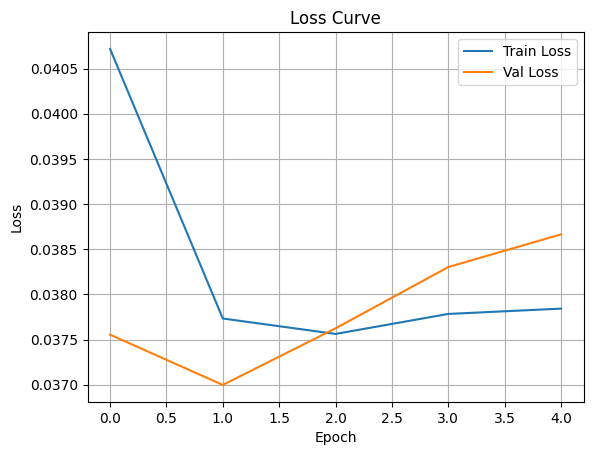

In [45]:
plot_training(history_hybrid_ncf)

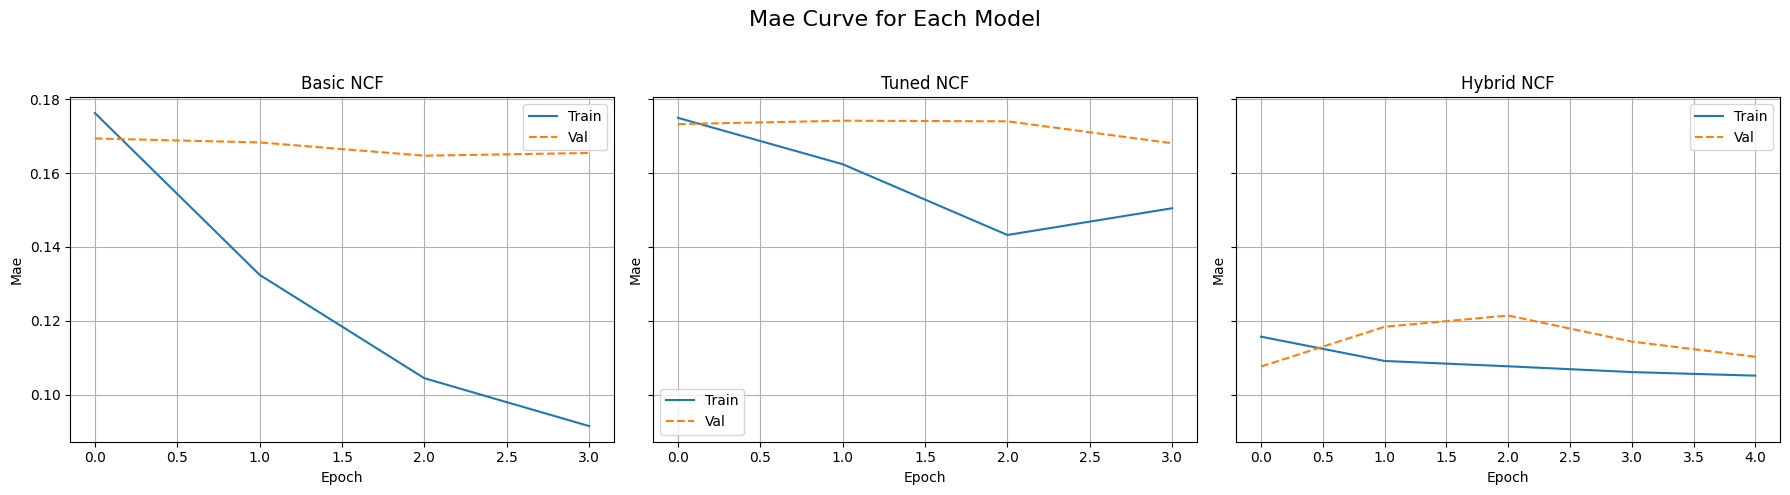

In [46]:

histories = [history_basic_ncf, history_ncf, history_hybrid_ncf]
labels = ['Basic NCF', 'Tuned NCF', 'Hybrid NCF']
metric='mae'
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, history, label in zip(axes, histories, labels):
    ax.plot(history.history[metric], label='Train')
    if f'val_{metric}' in history.history:
        ax.plot(history.history[f'val_{metric}'], linestyle='--', label='Val')
    ax.set_title(label)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.grid(True)
    ax.legend()

fig.suptitle(f'{metric.capitalize()} Curve for Each Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Final recommendations

In [47]:
def get_top_n_hybrid_recommendations(user_id, ncf_model, preferences=None, top_n=10):

    user_idx = user_encoder.transform([user_id])[0]

    # Get all recipe indices
    recipe_indices = np.arange(num_recipes)
    user_array = np.full(recipe_indices.shape, fill_value=user_idx)

    user_features = users_selected_features[user_idx].reshape(1, -1)
    user_features_array = np.repeat(user_features, recipe_indices.shape[0], axis=0)
    recipe_features_array = recipes_selected_features

    filtered_recipe_df = extended_recipes.copy()

    if preferences:
        for tag in recipe_tag_columns:
            if preferences.get(tag, 0) == 1:
                if tag in filtered_recipe_df.columns:
                    filtered_recipe_df = filtered_recipe_df[filtered_recipe_df[tag] == 1]

    filtered_recipe_indices = filtered_recipe_df['recipe_idx'].values
    if len(filtered_recipe_indices) == 0:
        return pd.DataFrame(columns=['recipe_idx', 'id', 'name', 'predicted_score'])

    user_array_filtered = np.full(filtered_recipe_indices.shape, fill_value=user_idx)
    user_features_array_filtered = np.repeat(user_features, filtered_recipe_indices.shape[0], axis=0)
    recipe_features_array_filtered = recipe_features_array[filtered_recipe_indices]

    predictions = ncf_model.predict([
        user_array_filtered,
        filtered_recipe_indices,
        user_features_array_filtered,
        recipe_features_array_filtered
    ], verbose=0).flatten()

    top_indices = predictions.argsort()[-top_n:][::-1]
    top_recipe_idxs = filtered_recipe_indices[top_indices]
    top_scores = predictions[top_indices]


    results = pd.DataFrame({
        'recipe_idx': top_recipe_idxs,
        'predicted_score': top_scores
    })

    recommended_recipes = results.merge(
        extended_recipes[['recipe_idx', 'id', 'name', 'tags']],
        on='recipe_idx',
        how='left'
    )

    recommended_recipes['predicted_score'] = pd.to_numeric(recommended_recipes['predicted_score'], errors='coerce')
    recommended_recipes = recommended_recipes.dropna(subset=['predicted_score'])
    return recommended_recipes.sort_values(by='predicted_score', ascending=False).reset_index(drop=True)


In [48]:
def print_user_recommendations(user_id, recommendations, recipes_df):
    print(f"\nTop Recommendations for User {user_id}:\n")

    for _, row in recommendations.iterrows():
        recipe_id = row['id']
        predicted_score = float(row['predicted_score'])

        recipe_row = recipes_df[recipes_df['id'] == recipe_id]
        if not recipe_row.empty:
            recipe_name = recipe_row['name'].values[0]
            recipe_tags = recipe_row['tags'].values[0]
        else:
            recipe_name = "(Unknown Recipe)"
            recipe_tags = []

        print(f"  User: {user_id} | Recipe: {recipe_id} ({recipe_name}) | Tags: {recipe_tags} | Predicted Score: {predicted_score:.2f}")


In [49]:
user_interaction_counts = extended_interactions['user_id'].value_counts()
np.random.seed(999)

# User with more than 10
random_user_candidates = user_interaction_counts[user_interaction_counts > 10].index.tolist()
random_user = np.random.choice(random_user_candidates)

In [50]:
top_5 = get_top_n_hybrid_recommendations(random_user, best_model_hybrid_ncf, preferences=None,top_n=5)
print_user_recommendations(random_user, top_5, extended_recipes)


Top Recommendations for User 54697:

  User: 54697 | Recipe: 431118 (tomato soup with artichokes  white beans  and roasted peppers) | Tags: ['time_to_make', 'cuisine', 'soups_stews', 'easy', 'european', '4_hours_or_less'] | Predicted Score: 1.00
  User: 54697 | Recipe: 401016 (grilled lamb shoulder chops with fresh mint sauce) | Tags: ['time_to_make', 'for_1_or_2', 'lamb_sheep', 'barbecue', 'dinner_party', 'meat', 'grilling', 'number_of_servings', '4_hours_or_less'] | Predicted Score: 0.98
  User: 54697 | Recipe: 357288 (weekend chicken and cheese enchiladas in green sauce) | Tags: ['time_to_make', 'cuisine', 'north_american', 'main_dish', 'poultry', 'mexican', 'chicken', 'one_dish_meal', 'inexpensive', 'meat', '4_hours_or_less'] | Predicted Score: 0.97
  User: 54697 | Recipe: 10744 (delicious chicken pot pie) | Tags: ['weeknight', 'time_to_make', 'cuisine', 'north_american', 'savory_pies', 'main_dish', 'potatoes', 'poultry', 'vegetables', 'american', 'oven', 'easy', 'potluck', 'dinne